# import copy
import pandas as pd
import pickle
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest, RFE, SelectFdr, RFECV
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error as mse
import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, regression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import plot_importance as xgb_importance
from lightgbm import plot_importance as lgb_importance
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import KFold
import itertools

In [30]:
def evaluate(X, y_cont, y_clf, model_reg, model_clf, score):

    cv = KFold(4, shuffle=True) # custom cv
    
    print('Cross-val-score, accuracy: {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring='accuracy', cv=cv, n_jobs=8).mean()))
    print('Cross-val-score, f1_score: {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring='f1', cv=cv, n_jobs=8).mean()))
    print('Cross-val-score, precision: {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring='precision', cv=cv, n_jobs=8).mean()))
    print('Cross-val-score, recall: {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring='recall', cv=cv, n_jobs=8).mean()))
    print('Cross-val-score, roc-auc: {:.4f}'.format(cross_val_score(model_clf, X, y_clf, scoring='roc_auc', cv=cv, n_jobs=8).mean()))
    
    print()
    
    model_clf.fit(X, y_clf)
    y_predicted = model_clf.predict(X)
    
    y1 = y_cont[y_predicted == 0]
    y2 = y_cont[y_predicted == 1]
    
    X1 = X[y_predicted == 0]
    X2 = X[y_predicted == 1]
    
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.7, random_state=42)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.7, random_state=42)    
    
    X_train, y_train = pd.concat((X1_train, X2_train)), pd.concat((y1_train, y2_train))
    X_test, y_test = pd.concat((X1_test, X2_test)), pd.concat((y1_test, y2_test))
    
    model_reg.fit(X_train, y_train)
    
    for sc in score:
        print(sc.__name__ + ' - исходная модель (test / train): {:.6f} / {:.6f}'.format(sc(model_reg.predict(X_test), y_test),
                                                                                      sc(model_reg.predict(X_train), y_train)))
        
        print('-' * 20)
    print()

    model_reg_inside1 = copy.copy(model_reg)
    model_reg_inside2 = copy.copy(model_reg)
    
    model_reg_inside1.fit(X1_train, y1_train)
    model_reg_inside2.fit(X2_train, y2_train)
    
    yts = np.concatenate((model_reg_inside1.predict(X1_test), model_reg_inside2.predict(X2_test)))
    ytr = np.concatenate((model_reg_inside1.predict(X1_train), model_reg_inside2.predict(X2_train)))
    
    for sc in score:
        print(sc.__name__ + ' - обработанная модель (test / train): {:.6f} / {:.6f}'.format(sc(yts, y_test), 
              sc(ytr, y_train))
             )  
        print('-' * 20)
    return model_clf, model_reg, model_reg_inside1, model_reg_inside2 

In [ ]:
def evaluate_silently(X, y_cont, y_clf, model_reg, model_clf, score):

    cv = KFold(X.shape[0], n_folds=4, shuffle=True) # custom cv

    model_clf.fit(X, y_clf)
    y_predicted = model_clf.predict(X)
    
    y1 = y_cont[y_predicted == 0]
    y2 = y_cont[y_predicted == 1]
    
    X1 = X[y_predicted == 0]
    X2 = X[y_predicted == 1]
    
    X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, train_size=0.7, random_state=42)
    X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, train_size=0.7, random_state=42)    
    
    X_train, y_train = pd.concat((X1_train, X2_train)), pd.concat((y1_train, y2_train))
    X_test, y_test = pd.concat((X1_test, X2_test)), pd.concat((y1_test, y2_test))
    
    model_reg.fit(X_train, y_train)
    
    score_reg1 = score(model_reg.predict(X_test), y_test)

    model_reg_inside1 = copy.copy(model_reg)
    model_reg_inside2 = copy.copy(model_reg)
    
    model_reg_inside1.fit(X1_train, y1_train)
    model_reg_inside2.fit(X2_train, y2_train)
    
    yts = np.concatenate((model_reg_inside1.predict(X1_test), model_reg_inside2.predict(X2_test)))
    ytr = np.concatenate((model_reg_inside1.predict(X1_train), model_reg_inside2.predict(X2_train)))
    
    score_reg2 = score(model_reg.predict(X_test), y_test)
    
    return score_reg1

In [ ]:
def most_common(model):
    t = sorted(list(zip(model.feature_importances_, M1.columns)), reverse=True)[:20]
    td = dict([v for v in t])
    td2 = {td[k]: k for k in td}
    return td2

In [20]:
y19 = pd.cut(y1, [0, 1.19, np.inf], labels=[0, 1], include_lowest=True)

In [2]:
def cartesian(inp):
    return list((dict(zip(inp.keys(), values)) for values in itertools.product(*inp.values())))

In [3]:
def prepare_arguments(lists):
    params = list(itertools.product(lists))
    d = {}
    for k, v in params:
        if k not in d:
            d[k] = []
            d[k].append(v)
        else:
            d[k].append(v)
    return d, params

In [4]:
def eliminate_by_one(data, target, features, model, arg={}):
    
    learned_models = []
    scores = []
    
    for feature in tqdm.tqdm(features):

        M = data.drop(columns=[feature])
        m = model(**arg)
        
        a = cross_val_score(m, M, target, scoring='r2', cv=KFold(data.shape[0], n_folds=8, shuffle=True), n_jobs=8).mean()
        b = cross_val_score(m, M, target, scoring='neg_mean_squared_error', cv=KFold(data.shape[0], n_folds=8, shuffle=True), n_jobs=8).mean()
        
        scores.append((feature, a, b))
        learned_models.append(m)
        
    return learned_models, scores

In [75]:
mo = pickle.load(open('./models/2lgb', 'rb'))

In [77]:
mo = mo[1]

In [87]:
M1.columns[68]

'Толщина'

In [80]:
def get_top20_features(model, names):
    return [i[1] for i in sorted(dict(zip(model.feature_importances_, M1.columns)).items(), key=lambda x: x[0], reverse=True)[:20]]

In [185]:
f

['Толщина',
 'Длина, м',
 'Тренд температуры конца прокатки (М12-02)',
 'Температура в HEF зона 1',
 'Содержание H2 в SF3 (MP1)',
 'Температура в SF3 зона 2',
 'Значение CO в SF1 (MP3)',
 'Температура полосы на левой моталке (проход 5)',
 'Содержание NH3 в SF3 (MP2)',
 'Содержание H2 в SF1 (MP4)',
 'Температура в RTF зона 4',
 'Точка росы в RTF',
 'Содержание H2 в HEF (MP1)',
 'Содержание H2 в SF1 (MP3)',
 'Температура полосы на левой моталке (проход 1)',
 'Ск_0.0028',
 'Температура в ATC1 зона 1',
 'Температура в SF3 зона 1',
 'Температура в SF1 зона 1',
 'Содержание H2 в SF1 (MP2)']

In [139]:
f = get_top20_features(pickle.load(open('./models/2lgb', 'rb'))[1], M1.columns)

In [176]:
a, b = eliminate_by_one(M1, y1, f, LGBMRegressor)


100%|██████████| 20/20 [04:19<00:00, 13.01s/it]


In [186]:
test_gbm = LGBMRegressor()

In [160]:
test_gbm.fit(M1.drop(columns=['Толщина']), y1)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [188]:
cross_val_score(test_gbm, M1, y1, cv=KFold(M1.shape[0], 8, True), scoring='neg_mean_squared_error').mean()

-0.0005679114385426987

In [189]:
sorted(list(zip(f, b)), key=lambda x: x[1][2])

[('Толщина', ('Толщина', 0.9688717698779534, -0.0006970583804656188)),
 ('Ск_0.0028', ('Ск_0.0028', 0.9770791574759295, -0.0005880796488466175)),
 ('Температура в ATC1 зона 1',
  ('Температура в ATC1 зона 1', 0.976946120858267, -0.0005517855848966543)),
 ('Температура в RTF зона 4',
  ('Температура в RTF зона 4', 0.976560738808923, -0.0005446404028223611)),
 ('Содержание H2 в SF1 (MP4)',
  ('Содержание H2 в SF1 (MP4)', 0.9761428941832406, -0.0005303459385252003)),
 ('Содержание H2 в HEF (MP1)',
  ('Содержание H2 в HEF (MP1)', 0.9767070871902039, -0.0005297961890880079)),
 ('Температура в SF1 зона 1',
  ('Температура в SF1 зона 1', 0.9770476193294687, -0.0005282368156462688)),
 ('Тренд температуры конца прокатки (М12-02)',
  ('Тренд температуры конца прокатки (М12-02)',
   0.977017409667448,
   -0.0005281016614591728)),
 ('Температура полосы на левой моталке (проход 5)',
  ('Температура полосы на левой моталке (проход 5)',
   0.9768515217151171,
   -0.0005186801143353893)),
 ('Длина, м'

In [179]:
a1, b1 = eliminate_by_one(M1, y1, f, XGBRegressor)


100%|██████████| 20/20 [32:36<00:00, 98.88s/it]


In [181]:
sorted(list(zip(f, b1)), key=lambda x: x[1][2])

[('Толщина', ('Толщина', 0.9151643317806023, -0.0018921114175268884)),
 ('Значение CO в SF1 (MP3)',
  ('Значение CO в SF1 (MP3)', 0.9268500077242052, -0.0017080135683053145)),
 ('Содержание H2 в SF1 (MP2)',
  ('Содержание H2 в SF1 (MP2)', 0.9256839034223909, -0.001684566123198606)),
 ('Температура в RTF зона 4',
  ('Температура в RTF зона 4', 0.9256962545935066, -0.0016792057263746688)),
 ('Температура в SF3 зона 1',
  ('Температура в SF3 зона 1', 0.9276671823178911, -0.0016663614148294643)),
 ('Содержание H2 в HEF (MP1)',
  ('Содержание H2 в HEF (MP1)', 0.9284931010185071, -0.0016618596108426194)),
 ('Содержание H2 в SF1 (MP4)',
  ('Содержание H2 в SF1 (MP4)', 0.9260674866942948, -0.001660949136229925)),
 ('Температура в SF1 зона 1',
  ('Температура в SF1 зона 1', 0.9270080233937975, -0.0016596449847505266)),
 ('Температура полосы на левой моталке (проход 1)',
  ('Температура полосы на левой моталке (проход 1)',
   0.9253209843867287,
   -0.0016525895623159801)),
 ('Содержание NH3 в S

In [218]:
params = {'n_estimators': [10 * k for k in range(1, 5)], 'max_depth': list(range(3, 10))}

In [230]:
res = []
for inp in tqdm.tqdm(cartesian(params)):
    res.append(evaluate_silently(M1, y1, y19, RandomForestRegressor(**inp), RandomForestClassifier(), mse))

100%|██████████| 28/28 [14:11<00:00, 55.74s/it]


In [237]:
p = sorted(list(zip(res, cartesian(params))))[0][1]

In [238]:
evaluate(M1, y1, y19, RandomForestRegressor(**p), RandomForestClassifier(), [r2_score, mse])

Cross-val-score, accuracy: 0.9956
Cross-val-score, f1_score: 0.9969
Cross-val-score, precision: 0.9976
Cross-val-score, recall: 0.9964
Cross-val-score, roc-auc: 0.9988

r2_score - исходная модель (test / train): 0.920927 / 0.929067
--------------------
mean_squared_error - исходная модель (test / train): 0.001535 / 0.001459
--------------------

r2_score - обработанная модель (test / train): 0.980422 / 0.985752
--------------------
mean_squared_error - обработанная модель (test / train): 0.000411 / 0.000315
--------------------


(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=Non

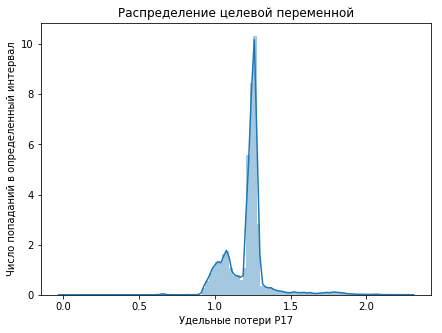

In [10]:
plt.figure(figsize=(7, 5))
sns.distplot(y1, bins=100)
plt.title('Распределение целевой переменной')
plt.ylabel('Число попаданий в определенный интервал')
plt.savefig('dist')

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
M2 = StandardScaler()

In [25]:
X = pd.DataFrame(M2.fit_transform(M1))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [32]:
a, b, c, d = evaluate(X, y1, y19, LinearRegression(), LogisticRegression(), [r2_score])

Cross-val-score, accuracy: 0.9781
Cross-val-score, f1_score: 0.9850
Cross-val-score, precision: 0.9851
Cross-val-score, recall: 0.9841
Cross-val-score, roc-auc: 0.9975



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


r2_score - исходная модель (test / train): 0.812468 / 0.823975
--------------------

r2_score - обработанная модель (test / train): 0.893396 / 0.901905
--------------------


In [113]:
def get_top20_features(model, names, title):

    xgb_importance({v: k for k, v in sorted(dict(zip(np.abs(a.coef_[0]), M1.columns)).items(), key=lambda x: x[0], reverse=True)[:20]}, show_values=False, height=1)
    plt.title(title)
    plt.xlabel('Feature Importance')

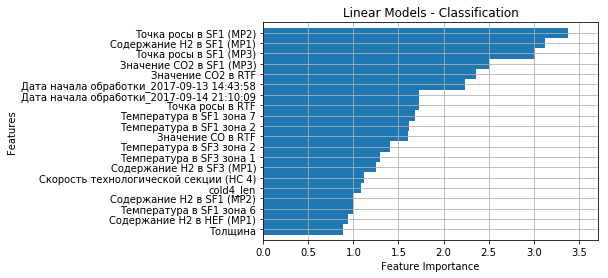

In [132]:
get_top20_features(a.coef_, M1.columns, 'Linear Models - Classification')


In [126]:
q = pickle.load(open('./models/2lrlr', 'rb'))

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.2 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your

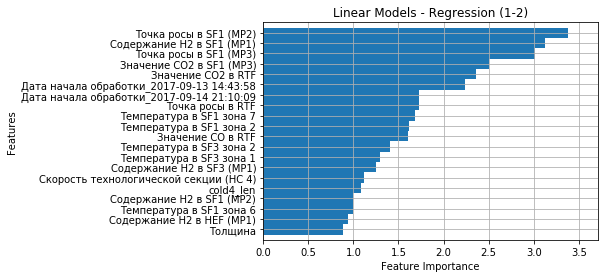

In [131]:
get_top20_features(q[0].coef_, M1.columns, 'Linear Models - Regression (1-2)')

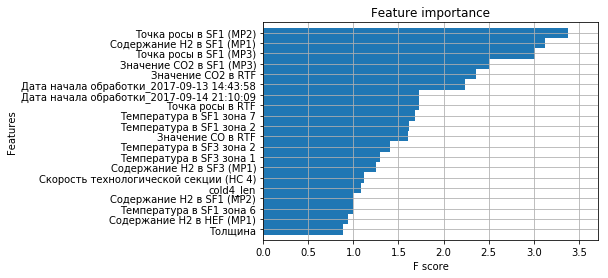

In [103]:
xgb_importance({v: k for k, v in sorted(dict(zip(np.abs(a.coef_[0]), M1.columns)).items(), key=lambda x: x[0], reverse=True)[:20]}, show_values=False, height=1)

In [359]:
pickle.dump([mc, mr, mr1, mr2], open('1rf', 'wb'))

In [321]:
mc, mr, mr1, mr2 = evaluate(M1, y1, y, RandomForestRegressor(), RandomForestClassifier(), [r2_score, mse])

Cross-val-score, accuracy: 0.9267
Cross-val-score, f1_score: 0.9335
Cross-val-score, precision: 0.9367
Cross-val-score, recall: 0.9330
Cross-val-score, roc-auc: 0.9625

r2_score - исходная модель (test / train): 0.988563 / 0.997269
--------------------
mean_squared_error - исходная модель (test / train): 0.000260 / 0.000060
--------------------

r2_score - обработанная модель (test / train): 0.991016 / 0.997219
--------------------
mean_squared_error - обработанная модель (test / train): 0.000204 / 0.000061
--------------------


In [101]:
mc, mr, mr1, mr2 = evaluate(M1, y1, y19, RandomForestRegressor(), RandomForestClassifier(), [r2_score, mse])

Cross-val-score, accuracy: 0.9953
Cross-val-score, f1_score: 0.9967
Cross-val-score, precision: 0.9975
Cross-val-score, recall: 0.9961
Cross-val-score, roc-auc: 0.9989

r2_score - исходная модель (test / train): 0.985642 / 0.996561
--------------------
mean_squared_error - исходная модель (test / train): 0.000303 / 0.000077
--------------------

r2_score - обработанная модель (test / train): 0.986309 / 0.997237
--------------------
mean_squared_error - обработанная модель (test / train): 0.000293 / 0.000062
--------------------


In [255]:
imp = sorted(dict(zip(M1.columns, mc.feature_importances_)).items(), key=lambda x: x[1], reverse=True)

In [258]:
dict(zip(M1.columns, mc.feature_importances_))['Толщина']

0.0012336447515382718

In [ ]:
evaluate(M1, y1, y19, LGBMRegressor(), LGBMRegressor(), [r2_score, mse])

In [360]:
pickle.dump([cl, ml, ml1, ml2], open('1lgbm', 'wb'))

In [324]:
cl, ml, ml1, ml2 = evaluate(M1, y1, y, LGBMRegressor(), LGBMClassifier(), [r2_score, mse])

Cross-val-score, accuracy: 0.8553
Cross-val-score, f1_score: 0.8757
Cross-val-score, precision: 0.8451
Cross-val-score, recall: 0.9087
Cross-val-score, roc-auc: 0.9372

r2_score - исходная модель (test / train): 0.975698 / 0.981970
--------------------
mean_squared_error - исходная модель (test / train): 0.000512 / 0.000391
--------------------

r2_score - обработанная модель (test / train): 0.977751 / 0.986993
--------------------
mean_squared_error - обработанная модель (test / train): 0.000475 / 0.000286
--------------------


In [335]:
t = sorted(list(zip(mr.feature_importances_, M1.columns)), reverse=True)[:20]
td = dict([v for v in t])
td2 = {td[k]: k for k in td}

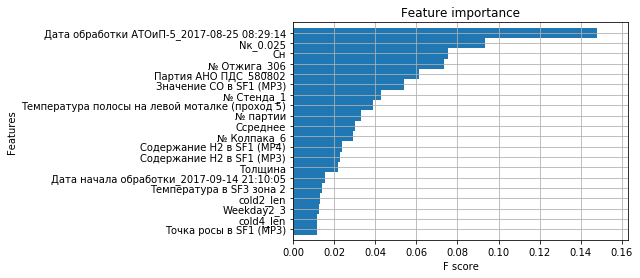

In [354]:
xgb_importance(td2, height=1, show_values=False)
plt.savefig('1rf_importance')

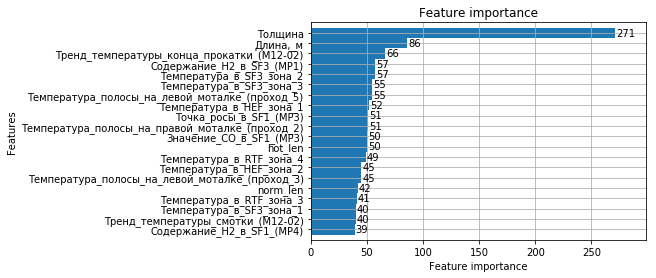

In [328]:
lgb_importance(ml, max_num_features=20, height=1)
plt.savefig('1lgb_importance')

In [74]:
evaluate(M1, y1, y19, XGBRegressor(), XGBClassifier(), [r2_score, mse])

Cross-val-score, accuracy: 0.9883

r2_score - исходная модель (test / train): 0.909207 / 0.910796
--------------------
mean_squared_error - исходная модель (test / train): 0.001603 / 0.001592
--------------------

r2_score - обработанная модель (test / train): 0.956658 / 0.961193
--------------------
mean_squared_error - обработанная модель (test / train): 0.000882 / 0.000797
--------------------


In [357]:
import pickle

In [361]:
pickle.dump([xc, xr, x1, x2], open('1xgb', 'wb'))

In [184]:
xc, xr, x1, x2 = evaluate(M1, y1, y, XGBRegressor(max_depth=10), XGBClassifier(max_depth=10), [r2_score, mse])

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Cross-val-score, accuracy: 0.9030


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Cross-val-score, f1_score: 0.9154


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Cross-val-score, precision: 0.8960


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

Cross-val-score, recall: 0.9358
Cross-val-score, roc-auc: 0.9569



KeyboardInterrupt: 

In [272]:
from sklearn.preprocessing import normalize

In [289]:
X = pd.DataFrame(normalize(M1, axis=0), columns=M1.columns)

In [284]:
evaluate(M1, y1, y19, LinearRegression(), LogisticRegression(), [r2_score, mse])

Cross-val-score, accuracy: 0.8692
Cross-val-score, f1_score: 0.9117
Cross-val-score, precision: 0.8883
Cross-val-score, recall: 0.9365
Cross-val-score, roc-auc: 0.9076

r2_score - исходная модель (test / train): 0.821719 / 0.820292
--------------------
mean_squared_error - исходная модель (test / train): 0.003354 / 0.003427
--------------------

r2_score - обработанная модель (test / train): -0.000114 / 0.868696
--------------------
mean_squared_error - обработанная модель (test / train): 4502.915997 / 0.002611
--------------------


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))

In [312]:
from sklearn.linear_model import Ridge, Lasso

In [362]:
pickle.dump([c, r, r1, r2], open('1lrlr', 'wb'))

In [320]:
c, r, r1, r2 = evaluate(X, y1, y, LinearRegression(), LogisticRegression(), [r2_score, mse])

Cross-val-score, accuracy: 0.7533
Cross-val-score, f1_score: 0.7556
Cross-val-score, precision: 0.8505
Cross-val-score, recall: 0.6798
Cross-val-score, roc-auc: 0.8459

r2_score - исходная модель (test / train): 0.819602 / 0.820785
--------------------
mean_squared_error - исходная модель (test / train): 0.003346 / 0.003436
--------------------

r2_score - обработанная модель (test / train): 0.868533 / 0.876305
--------------------
mean_squared_error - обработанная модель (test / train): 0.002560 / 0.002489
--------------------


In [319]:
sorted(list(zip(r.coef_, M1.columns)))

[(-1.683045118289414, 'Дата начала обработки_2017-09-13 14:44:15'),
 (-1.1442737462394874, 'Дата обработки АТОиП-5_2017-08-26 05:33:24'),
 (-1.1442737462394872, '№ партии АТОиП№5_580815'),
 (-1.1442737462394854, 'Партия АНО ПДС_580815'),
 (-0.9157900542283696, 'Weekday2_5'),
 (-0.8796929452980257, 'Дата начала обработки_2017-08-29 22:20:26'),
 (-0.8640626397947138, 'Дата начала обработки_2017-08-28 22:59:34'),
 (-0.8383137115379861, 'Партия АНО ПДС_580817'),
 (-0.838313711537986, 'Дата обработки АТОиП-5_2017-08-26 09:15:12'),
 (-0.8383137115379853, '№ партии АТОиП№5_580817'),
 (-0.7745433656618567, 'Nк_0.023'),
 (-0.7379652349451471, 'Дата начала обработки_2017-08-29 22:20:03'),
 (-0.7162403178654357, 'Дата начала обработки_2017-09-14 21:10:20'),
 (-0.7087886649721364, '№ Колпака_140'),
 (-0.7087886649721347, '№ Стенда_139'),
 (-0.7087886649721326, 'Стенд_139'),
 (-0.7087886649721326, '№ Отжига_430'),
 (-0.6792974593205878, 'Дата начала обработки_2017-09-13 15:08:09'),
 (-0.63834510673

In [3]:
import keras 
import keras.backend as K

In [2]:
from keras.models import load_model

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [4]:
model = load_model('./my_model.h5')

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               47616     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2600      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2624      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 371)               47859     
Total params: 117,275
Trainable params: 117,275
Non-trainable params: 0
_________________________________________________________________


In [12]:
get_3rd_layer_output = K.function([model.layers[0].input],
                                  [model.layers[2].output])
layer_output = get_3rd_layer_output([M1])[0]

In [13]:
layer_output.shape

(48503, 40)

In [14]:
xgb_t = XGBRegressor(max_depth=15)

In [15]:
cross_val_score(xgb_t, layer_output, y1, scoring='neg_mean_squared_error', cv=KFold(shuffle=True))

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:426: FutureWarning: You should specify a value for 'n_splits' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


array([-0.01005074, -0.00928663, -0.00909936])

In [17]:
np.array([-0.01005074, -0.00928663, -0.00909936]).mean()

-0.00947891

In [18]:
0.01

0.01

In [76]:
y = pd.cut(y1, [0, 1.05, 1.26, np.inf], labels=[0, 1, 2], include_lowest=True)
y[y == 2] = 0

In [78]:
evaluate(M1, y1, y, RandomForestRegressor(), RandomForestClassifier(), [r2_score, mse])

Cross-val-score, accuracy: 0.9275

r2_score - исходная модель (test / train): 0.978338 / 0.997578
--------------------
mean_squared_error - исходная модель (test / train): 0.000489 / 0.000053
--------------------

r2_score - обработанная модель (test / train): 0.983327 / 0.998000
--------------------
mean_squared_error - обработанная модель (test / train): 0.000377 / 0.000044
--------------------


In [79]:
evaluate(M1, y1, y, XGBRegressor(), XGBClassifier(), [r2_score, mse])

Cross-val-score, accuracy: 0.7961

r2_score - исходная модель (test / train): 0.894892 / 0.910810
--------------------
mean_squared_error - исходная модель (test / train): 0.001826 / 0.001578
--------------------

r2_score - обработанная модель (test / train): 0.938716 / 0.952345
--------------------
mean_squared_error - обработанная модель (test / train): 0.001184 / 0.000941
--------------------


In [80]:
evaluate(M1, y1, y, LinearRegression(), LogisticRegression(), [r2_score, mse])

Cross-val-score, accuracy: 0.6915

r2_score - исходная модель (test / train): 0.812853 / 0.823544
--------------------
mean_squared_error - исходная модель (test / train): 0.003542 / 0.003347
--------------------

r2_score - обработанная модель (test / train): 0.000161 / 0.863281
--------------------
mean_squared_error - обработанная модель (test / train): 158.331376 / 0.002684
--------------------


In [411]:
skb = SelectKBest(k=100)
X_skb = skb.fit_transform(M1, y)

In [412]:
rf_skb = RandomForestRegressor()
kfold = KFold(M1.shape[0], n_folds=4, shuffle=True)
cross_val_score(rf_skb, X_skb, y1, cv=kfold, scoring='r2')

array([0.97902878, 0.97167163, 0.97548224, 0.96935439])

In [410]:
np.array([0.97654907, 0.98953846, 0.98000229, 0.98769288]).mean()

0.983445675

In [416]:
rf_skb = RandomForestRegressor()
kfold = KFold(M1.shape[0], n_folds=4, shuffle=True)
rfecv = RFECV(rf_skb, step=5, cv=kfold, scoring='r2', n_jobs=4)

In [418]:
rfecv.fit(M1, y1)

RFECV(cv=sklearn.cross_validation.KFold(n=48503, n_folds=4, shuffle=True, random_state=None),
   estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
   n_jobs=4, scoring='r2', step=5, verbose=0)

In [448]:
most_common(mr)

{'Дата обработки АТОиП-5_2017-08-25 08:29:14': 0.14814557417402696,
 'Nк_0.025': 0.09361583891515303,
 'Cн': 0.0752947244457643,
 '№ Отжига_306': 0.0736050474527678,
 'Партия АНО ПДС_580802': 0.0612614156226333,
 'Значение CO в SF1 (MP3)': 0.05406852096641612,
 '№ Стенда_1': 0.04297171857621216,
 'Температура полосы на левой моталке (проход 5)': 0.03904982336426178,
 '№ партии': 0.03291797933954711,
 'Ссреднее': 0.03024912116161335,
 '№ Колпака_6': 0.029222265766443455,
 'Содержание H2 в SF1 (MP4)': 0.023831959395641217,
 'Содержание H2 в SF1 (MP3)': 0.022884169685379097,
 'Толщина': 0.022010353492259976,
 'Дата начала обработки_2017-09-14 21:10:05': 0.01541633709052701,
 'Температура в SF3 зона 2': 0.013848725395054893,
 'cold2_len': 0.013087185302159854,
 'Weekday2_3': 0.012583522772594297,
 'cold4_len': 0.011860392051124696,
 'Точка росы в SF1 (MP3)': 0.011810850924553291}

In [ ]:
mr.feature_importances_

In [439]:
cnames = M1.columns[rfecv.get_support()]

In [435]:
rfecv.inverse_transform(rfecv.transform(M1))

(48503, 371)

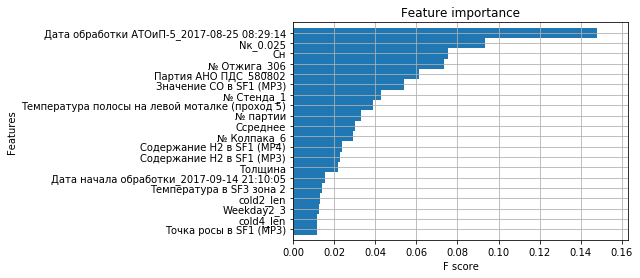

In [446]:
# old
xgb_importance(td2, show_values=False, height=1)

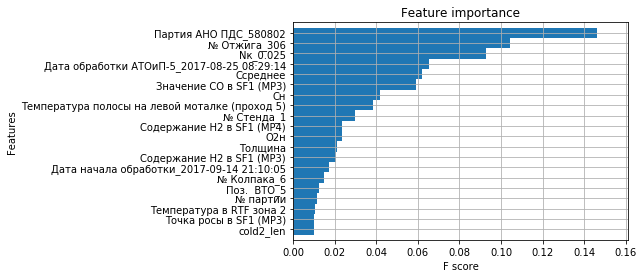

In [443]:
#after selection
xgb_importance(td2, show_values=False, height=1)

#### Also, RFECV

In [15]:
skb = LinearRegression(n_jobs=4)
kfold = KFold(M1.shape[0], n_folds=4, shuffle=True)
rfecv = RFECV(skb, step=5, cv=kfold, scoring='r2', n_jobs=4)
rfecv.fit(M1, y1)

RFECV(cv=sklearn.cross_validation.KFold(n=48503, n_folds=4, shuffle=True, random_state=None),
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False),
   n_jobs=4, scoring='r2', step=5, verbose=0)

In [16]:
skb = XGBRegressor(max_depth=10)
kfold = KFold(M1.shape[0], n_folds=4, shuffle=True)
rfecv_xgb = RFECV(skb, step=5, cv=kfold, scoring='r2', n_jobs=4)
rfecv_xgb.fit(M1, y1)

RFECV(cv=sklearn.cross_validation.KFold(n=48503, n_folds=4, shuffle=True, random_state=None),
   estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
   n_jobs=4, scoring='r2', step=5, verbose=0)

In [24]:
M1.columns[rfecv_xgb.get_support()]

Index(['№ партии', 'Длина, м', 'Тренд температуры за 5-й кл. (M12-02)',
       'Тренд толщины за 12-й кл.',
       'Тренд температуры конца прокатки (М12-02)',
       'Тренд температуры смотки (M12-02)', 'hot_len',
       'Температура полосы в зоне 4', 'Температура полосы в зоне 7',
       'Температура полосы в зоне 4B  АН',
       ...
       'Дата начала обработки_2017-09-12 22:46:34',
       'Дата начала обработки_2017-09-13 15:07:58',
       'Дата начала обработки_2017-09-13 15:08:01',
       'Дата начала обработки_2017-09-13 15:08:26',
       'Дата начала обработки_2017-09-14 14:54:31',
       'Дата начала обработки_2017-09-14 21:10:05',
       'Дата начала обработки_2017-09-14 21:10:15', 'Weekday2_3', 'Weekday2_4',
       'Nн_0.025'],
      dtype='object', length=111)

(array([2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 6.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.3000e+01, 1.0000e+00, 6.0000e+00,
        4.0000e+00, 6.6000e+01, 6.0000e+00, 0.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 5.0000e+00, 4.0000e+00, 2.0000e+00,
        3.0000e+00, 1.2000e+01, 1.4300e+03, 1.0600e+03, 6.8000e+01,
        4.5710e+03, 4.0723e+04, 4.3200e+02, 1.6000e+01, 4.0000e+00,
        8.0000e+00, 0.0000e+00, 2.0000e+00, 1.8000e+01, 2.0000e+00,
        6.0000e+00, 4.0000e+00, 1.4000e+01, 4.0000e+00, 1.0000e+00]),
 array([0.08  , 0.0857, 0.0914, 0.0971, 0.1028, 0.1085, 0.1142, 0.1199,
        0.1256, 0.1313, 0.137 , 0.1427, 0.1484, 0.1541, 0.1598, 0.1655,
        0.1712, 0.1769, 0.1826, 0.1883, 0.194 , 0.1997, 0.2054, 0.2111,
        0.2168, 0.2225, 0.2282, 0.2339, 0.2396, 0.2453, 0.251 , 0.2567,
        0.2624, 0.2681, 0.2738

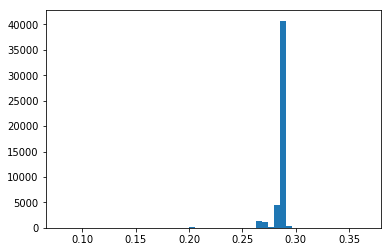

In [34]:
plt.hist(M1['Толщина'], bins=50)

(array([4.0000e+00, 2.0000e+00, 4.0000e+00, 1.0000e+00, 3.0000e+00,
        2.0000e+00, 3.0000e+00, 3.0000e+00, 9.8000e+01, 8.3000e+01,
        7.3000e+01, 8.0000e+01, 7.7000e+01, 7.8000e+01, 8.1000e+01,
        7.7000e+01, 2.7400e+02, 7.3000e+01, 8.2000e+01, 9.0000e+01,
        6.5000e+01, 8.4000e+01, 1.0400e+02, 6.4000e+01, 1.9000e+03,
        3.6600e+02, 3.2100e+02, 3.6300e+02, 3.5100e+02, 3.5700e+02,
        3.2800e+02, 3.7500e+02, 2.9600e+02, 2.3740e+03, 3.7200e+02,
        4.4700e+02, 4.2000e+02, 4.6400e+02, 4.2200e+02, 4.4800e+02,
        4.2700e+02, 5.1680e+03, 9.9700e+02, 1.0260e+03, 1.0210e+03,
        1.0480e+03, 1.0580e+03, 1.0590e+03, 1.0160e+03, 1.2232e+04,
        1.0940e+03, 1.1480e+03, 1.0730e+03, 1.1240e+03, 1.1490e+03,
        1.0880e+03, 1.1180e+03, 1.1520e+03, 2.2320e+03, 7.3000e+01,
        6.4000e+01, 7.5000e+01, 7.5000e+01, 6.5000e+01, 7.0000e+01,
        7.6000e+01, 2.1900e+02, 1.5000e+01, 1.2000e+01, 1.8000e+01,
        1.3000e+01, 1.6000e+01, 1.5000e+01, 1.30

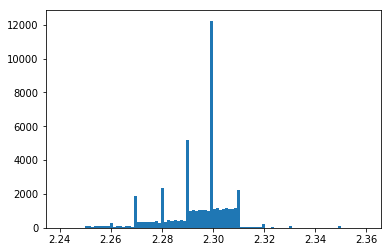

In [33]:
plt.hist(M1['Тренд толщины за 12-й кл.'], bins=100)

In [40]:
for n, i in enumerate(list(M1.columns)):
    if i == 'Толщина':
        print(n)

68


In [27]:
M1.columns[rfecv_xgb.get_support()]

Index(['№ партии', 'Длина, м', 'Тренд температуры за 5-й кл. (M12-02)',
       'Тренд толщины за 12-й кл.',
       'Тренд температуры конца прокатки (М12-02)',
       'Тренд температуры смотки (M12-02)', 'hot_len',
       'Температура полосы в зоне 4', 'Температура полосы в зоне 7',
       'Температура полосы в зоне 4B  АН',
       ...
       'Дата начала обработки_2017-09-12 22:46:34',
       'Дата начала обработки_2017-09-13 15:07:58',
       'Дата начала обработки_2017-09-13 15:08:01',
       'Дата начала обработки_2017-09-13 15:08:26',
       'Дата начала обработки_2017-09-14 14:54:31',
       'Дата начала обработки_2017-09-14 21:10:05',
       'Дата начала обработки_2017-09-14 21:10:15', 'Weekday2_3', 'Weekday2_4',
       'Nн_0.025'],
      dtype='object', length=111)

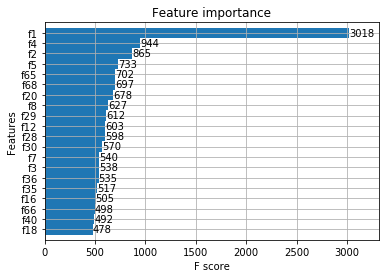

In [21]:
xgb_importance(rfecv_xgb.estimator_, max_num_features=20, height=1)

In [36]:
pickle.dump(rfecv_xgb, open('xgb_rfecv', 'wb'))

In [ ]:
skb = LGBMRegressor()
kfold = KFold(M1.shape[0], n_folds=4, shuffle=True)
rfecv_lgb = RFECV(skb, step=5, cv=kfold, scoring='r2', n_jobs=4)
rfecv_lgb.fit(M1, y1)

In [422]:
M1.shape

(48503, 371)

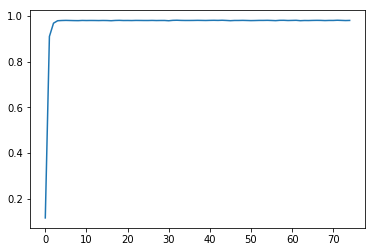

In [426]:
plt.plot(rfecv.grid_scores_)

In [363]:
l, lr, lr1, lr2 = evaluate(M1, y1, y19, LinearRegression(), LogisticRegression(), [r2_score, mse])

Cross-val-score, accuracy: 0.8773
Cross-val-score, f1_score: 0.9166
Cross-val-score, precision: 0.8990
Cross-val-score, recall: 0.9349
Cross-val-score, roc-auc: 0.9195

r2_score - исходная модель (test / train): 0.821719 / 0.820292
--------------------
mean_squared_error - исходная модель (test / train): 0.003354 / 0.003427
--------------------

r2_score - обработанная модель (test / train): -0.000114 / 0.868696
--------------------
mean_squared_error - обработанная модель (test / train): 4502.915997 / 0.002611
--------------------


In [364]:
rf, rfr, rf1, rf2 = evaluate(M1, y1, y19, RandomForestRegressor(), RandomForestClassifier(), [r2_score, mse])

Cross-val-score, accuracy: 0.9953
Cross-val-score, f1_score: 0.9967
Cross-val-score, precision: 0.9972
Cross-val-score, recall: 0.9963
Cross-val-score, roc-auc: 0.9989

r2_score - исходная модель (test / train): 0.982320 / 0.997678
--------------------
mean_squared_error - исходная модель (test / train): 0.000390 / 0.000051
--------------------

r2_score - обработанная модель (test / train): 0.980040 / 0.997988
--------------------
mean_squared_error - обработанная модель (test / train): 0.000443 / 0.000045
--------------------


In [365]:
xg, xgr, xgr1, xgr2 = evaluate(M1, y1, y19, XGBRegressor(), XGBClassifier(),  [r2_score, mse])

Cross-val-score, accuracy: 0.9881
Cross-val-score, f1_score: 0.9917
Cross-val-score, precision: 0.9918
Cross-val-score, recall: 0.9916
Cross-val-score, roc-auc: 0.9987

r2_score - исходная модель (test / train): 0.909207 / 0.910796
--------------------
mean_squared_error - исходная модель (test / train): 0.001603 / 0.001592
--------------------

r2_score - обработанная модель (test / train): 0.956658 / 0.961193
--------------------
mean_squared_error - обработанная модель (test / train): 0.000882 / 0.000797
--------------------


In [366]:
lg, lgr, lg1, lg2 = evaluate(M1, y1, y19, LGBMRegressor(), LGBMClassifier(), [r2_score, mse])

Cross-val-score, accuracy: 0.9955
Cross-val-score, f1_score: 0.9969
Cross-val-score, precision: 0.9969
Cross-val-score, recall: 0.9968
Cross-val-score, roc-auc: 0.9998

r2_score - исходная модель (test / train): 0.973351 / 0.981957
--------------------
mean_squared_error - исходная модель (test / train): 0.000571 / 0.000388
--------------------

r2_score - обработанная модель (test / train): 0.984276 / 0.988581
--------------------
mean_squared_error - обработанная модель (test / train): 0.000343 / 0.000249
--------------------


In [367]:
pickle.dump([l, lr, lr1, lr2], open('2lrlr', 'wb'))
pickle.dump([rf, rfr, rf1, rf2], open('2rf', 'wb'))
pickle.dump([xg, xgr, xgr1, xgr2], open('2xgb', 'wb'))
pickle.dump([lg, lgr, lg1, lg2], open('2lgb', 'wb'))

In [374]:
from sklearn.feature_selection import 

In [8]:
def daytime(x):
        if x.hour >= 12 and x.hour <= 24:
            return 'Day'
        if x.hour > 0 and x.hour < 12:
            return 'Night'

In [9]:
def read_data():
    d1 = pd.read_csv('./d1.csv')
    d2 = pd.read_csv('./d2.csv')
    d1 = d1.dropna()
    d2 = d2.dropna(axis=1, thresh=5000) 
    d2.rename(columns={'P17': 'Удельные потери P17'}, inplace=True)
    return d1, d2

In [10]:
def preprocess(d1):
    d1['Стенд/Отжиг/Поз.  ВТО'] = d1['Стенд/Отжиг/Поз.  ВТО'].fillna('')
    d1 = pd.concat([d1, d1['Стенд/Отжиг/Поз.  ВТО'].apply(lambda x: pd.Series(x.split('/')), 1).rename(columns={0: 'Стенд', 1: 'Отжиг', 2: 'Поз.  ВТО'})], axis=1)
    d1.drop(columns='Отжиг', inplace=True)
    l = []
    
    for col in d1.columns:
        l.append(len(pd.unique(d1[col])))
    uniqness = pd.DataFrame({'name': d1.columns, 'len': l})
    d1.drop(columns=uniqness[uniqness['len'] == 1]['name'].values, inplace=True)

    d1['Daytime1'] = d1['Дата начала обработки'].apply(lambda x: daytime(pd.to_datetime(x)), 1)
    d1['Weekday1'] = d1['Дата начала обработки'].apply(lambda x: pd.to_datetime(x).weekday(), 1)

    d1['Daytime2'] = d1['Дата обработки АТОиП-5'].apply(lambda x: daytime(pd.to_datetime(x)), 1)
    d1['Weekday2'] = d1['Дата обработки АТОиП-5'].apply(lambda x: pd.to_datetime(x).weekday(), 1)

    cat_columns = list(uniqness[uniqness['len'] <= 16]['name'].values) + \
    ['Партия АНО ПДС', '№ партии АТОиП№5', 'Дата обработки АТОиП-5', 'Дата начала обработки', 'Daytime1', 'Weekday1', 'Daytime2', 'Weekday2']
    cat_columns
    
    y = d1['Удельные потери P17']
    X = d1.drop(columns=['Удельные потери P17'])
    
    M = pd.get_dummies(X, columns=list(set(cat_columns).intersection(set(d1.columns))))
    return M, y

In [11]:
d1, d2 = read_data()
M1, y1 = preprocess(d1)
M2, y2 = preprocess(d2)
M1.drop(columns=['Стенд/Отжиг/Поз.  ВТО', 'Р17ср'], inplace=True)

In [53]:
lr = LinearRegression()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(M1, y1, train_size=0.7)

In [13]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [15]:
r2_score(lr.predict(X_test), y_test)

0.8216629681036802

In [16]:
mse(lr.predict(X_test), y_test)

0.003424057836996756

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
y = pd.cut(y1, [0, 1.05, 1.26, np.inf], labels=[0, 1, 2], include_lowest=True)
y[y==2] = 0
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.7)

In [53]:
lr_clf = LogisticRegression()

In [54]:
lr_clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [55]:
accuracy_score(lr_clf.predict(X_test), y_test)

0.6925984468421414

### Random forest

In [33]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [183]:
y = pd.cut(y1, [0, 1.05, 1.26, np.inf], labels=[0, 1, 2], include_lowest=True)
y[y==2] = 0
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.7)

In [47]:
rf = RandomForestClassifier(n_estimators=20,)

In [48]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
accuracy_score(rf.predict(X_train), y_train)

0.9980560791705938

In [43]:
l = lgb.LGBMClassifier(max_depth=20)

In [44]:
l.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=20,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [45]:
accuracy_score(l.predict(X_train), y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8789762016965127

### XGB

In [113]:
from xgboost import XGBClassifier, XGBRegressor

In [114]:
xgb = XGBClassifier(max_depth=10)

In [115]:
y = pd.cut(y1, [0, 1.19, np.inf], include_lowest=True, labels=[0, 1])

In [116]:
xgb.fit(M1, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [117]:
accuracy_score(xgb.predict(X_train), y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9999742281325705

In [118]:
accuracy_score(xgb.predict(X_test), y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9997938356870426

In [127]:
predictions = xgb.predict(M1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [132]:
xgbreg_0 = XGBRegressor(max_depth=10, )

In [136]:
X_0 = M1[predictions == 0]
y_0 = y1[predictions == 0]
X_1 = M1[predictions == 1]
y_1 = y1[predictions == 1]

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X_0, y_0, train_size=0.7)

In [138]:
xgbreg_0.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [142]:
print(r2_score(xgbreg_0.predict(X_train), y_train))
print(r2_score(xgbreg_0.predict(X_test), y_test))

0.9940847447078055
0.9777507208923486


In [146]:
std_0 = y_0.std()

In [147]:
print(mse(xgbreg_0.predict(X_train), y_train)/std_0)
print(mse(xgbreg_0.predict(X_test), y_test)/std_0)

0.0004361535300901298
0.0016304147415726364


In [148]:
xgbreg = XGBRegressor(max_depth=10)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(M1, y1, train_size=0.7)

In [156]:
xgbreg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [158]:
mse(xgbreg.predict(X_test), y_test)/std

0.03542898247878967

In [162]:
M1.corrwith(y1).sort_values()

№ плавки_1717431                             -0.342994
Азот_0.0077                                  -0.342994
Титан_0.003                                  -0.342994
Кремний_3.3310000000000004                   -0.342994
Углерод_0.054000000000000006                 -0.342994
Weekday2_5                                   -0.328720
Nк_0.023                                     -0.311614
Nн_0.022000000000000002                      -0.308482
№ Стенда_139                                 -0.308081
Стенд_139                                    -0.308081
№ Колпака_140                                -0.308081
№ Отжига_430                                 -0.308081
Тренд температуры конца прокатки (М12-02)    -0.290843
Фосфор_0.024                                 -0.274371
Nсреднее_0.0225                              -0.268095
Nсреднее_0.022000000000000002                -0.267017
Партия АНО ПДС_580817                        -0.255896
Дата обработки АТОиП-5_2017-08-26 09:15:12   -0.255896
№ партии А

### Peaks classification

In [134]:
y = pd.cut(y1, [0, 1.19, np.inf], include_lowest=True, labels=[0, 1])

In [111]:
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.8)

In [83]:
pclass = lgb.LGBMClassifier()
pclass.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [84]:
predictions = pclass.predict(M1)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [85]:
accuracy_score(predictions, y)

0.9983300002061728

In [52]:
import seaborn as sns

Text(0, 0.5, 'Количество попаданий целевой переменной \n в определенный интервал')

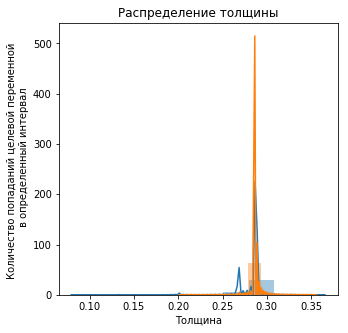

In [141]:
plt.figure(figsize=(5, 5))
plt.title('Распределение толщины')
sns.distplot(M1[y == 0]['Толщина'], bins=10)
sns.distplot(M1[y == 1]['Толщина'], bins=10)
plt.ylabel('Количество попаданий целевой переменной \n в определенный интервал')

In [74]:
new = pd.concat((M1, pd.Series(y1, name='Потери'), y), axis=1)

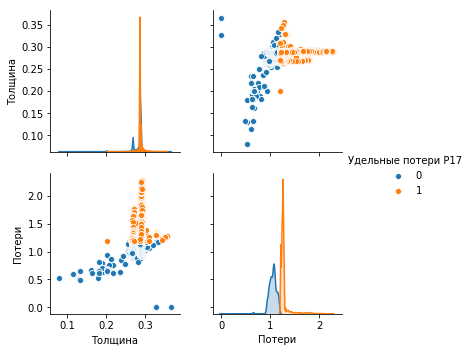

In [79]:
sns.pairplot(new, hue='Удельные потери P17', vars=['Толщина', 'Потери'], )

In [86]:
first = M1[predictions==0]
y11 = y1[predictions==0]
second = M1[predictions==1]
y22 = y1[predictions==1]

In [95]:
std = M1[y == 0]['Толщина'].std()

In [97]:
reg = lgb.LGBMRegressor()
X_train, X_test, y_train, y_test = train_test_split(first, y11, train_size=0.7 )
reg.fit(X_train, y_train)
r2_score(reg.predict(X_test), y_test)
print(mse(reg.predict(X_test), y_test)/std)

0.03957280764191099


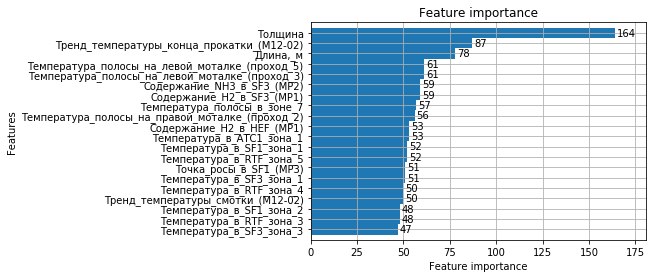

In [14]:
lgb.plot_importance(reg, max_num_features=20, height=1)

In [98]:
reg = lgb.LGBMRegressor()
X_train, X_test, y_train, y_test = train_test_split(second, y22, train_size=0.7 )
reg.fit(X_train, y_train)
r2_score(reg.predict(X_test), y_test)
print(mse(reg.predict(X_test), y_test)/std)

0.03302031910716914


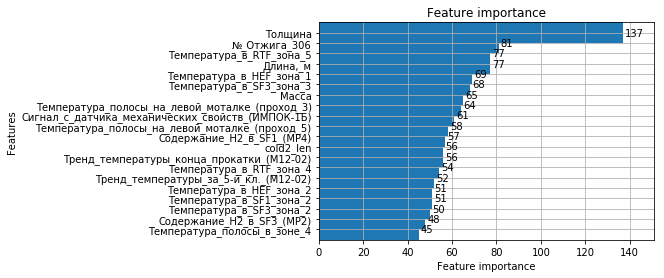

In [20]:
lgb.plot_importance(pclass, max_num_features=20, height=2)

### Whole regression 

In [42]:
X_train, X_test, y_train, y_test = train_test_split(M1, y1, train_size=0.7)

In [43]:
whole_reg = lgb.LGBMRegressor()

In [44]:
whole_reg.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [45]:
r2_score(whole_reg.predict(X_test), y_test)

0.9768090872674671

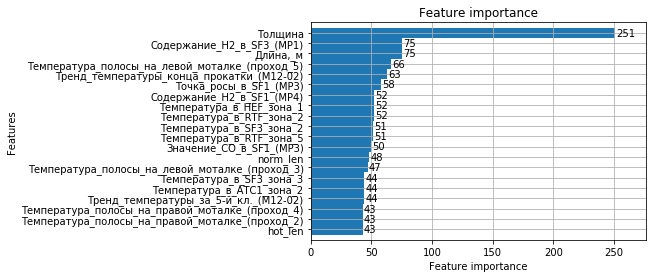

In [50]:
lgb_importance(whole_reg, max_num_features=20, height=1)

In [47]:
mse(whole_reg.predict(X_test), y_test)

0.0005051494445293427

Only width

In [21]:
fat = lgb.LGBMClassifier()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.8)
fat.fit(np.array(X_train['Толщина']).reshape(-1, 1), y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [30]:
accuracy_score(fat.predict(np.array(X_test['Толщина']).reshape(-1, 1)), y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8484692299762912

### Regression between peaks

In [144]:
below = M1[y1 <= 1.19]
y_below = y1[y1 <= 1.19]
under = M1[y1 > 1.19]
y_under = y1[y1 > 1.19]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(below, y_below, train_size=0.8)
rbelow = lgb.LGBMRegressor()
rbelow.fit(X_train, y_train)

In [149]:
r2_score(rbelow.predict(X_test), y_test)

0.9467821578041674

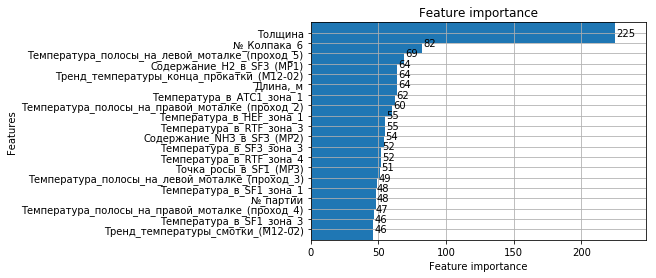

In [150]:
lgb.plot_importance(rbelow, max_num_features=20, height=2)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(under, y_under, train_size=0.8)

In [153]:
runder = lgb.LGBMRegressor()
runder.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [155]:
r2_score(runder.predict(X_test), y_test)

0.9729102176469872

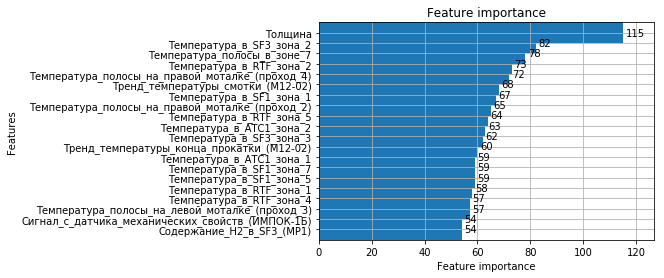

In [156]:
lgb.plot_importance(runder, max_num_features=20, height=2)

#### WIthout width

In [158]:
below = M1.drop(columns='Толщина')[y1 <= 1.19]
y_below = y1[y1 <= 1.19]
under = M1.drop(columns='Толщина')[y1 > 1.19]
y_under = y1[y1 > 1.19]

In [159]:
X_train, X_test, y_train, y_test = train_test_split(below, y_below, train_size=0.8)
rbelow = lgb.LGBMRegressor()
rbelow.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [160]:
r2_score(rbelow.predict(X_test), y_test)

0.8740714576626056

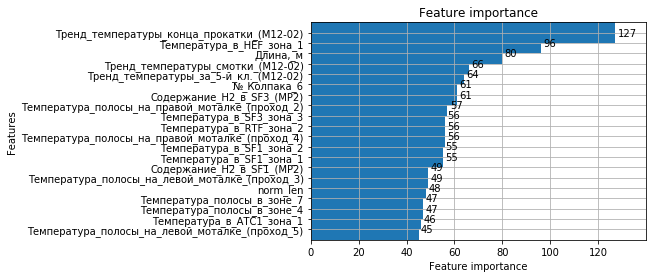

In [161]:
lgb.plot_importance(rbelow, max_num_features=20, height=2)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(under, y_under, train_size=0.8)

In [166]:
runder = lgb.LGBMRegressor()
runder.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [167]:
r2_score(runder.predict(X_test), y_test)

0.9682647949361932

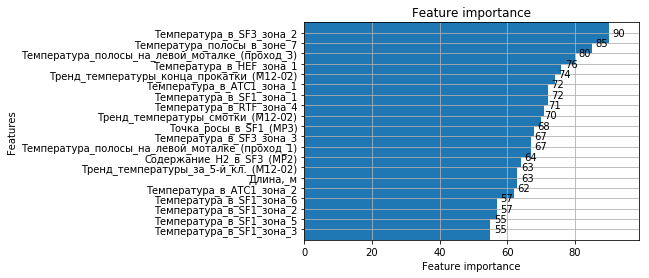

In [168]:
lgb.plot_importance(runder, max_num_features=20, height=2)

### Binary classification 

In [20]:
y = pd.cut(y1, [0, 1.05, 1.26, np.inf], include_lowest=True, labels=[0, 1, 2])

In [22]:
y[y==2]= 0

In [24]:
y.value_counts()

1    27213
0    21290
2        0
Name: Удельные потери P17, dtype: int64

In [27]:
y1.head()

742    1.246
743    1.271
744    1.260
745    1.263
746    1.273
Name: Удельные потери P17, dtype: float64

In [28]:
y.head()

742    1
743    0
744    1
745    0
746    0
Name: Удельные потери P17, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [29]:
clf = lgb.LGBMClassifier()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(M1, y, train_size=0.7)

In [41]:
from sklearn.metrics import precision_score, recall_score

In [42]:
clf.fit(X_train, y_train)

print('Test accuracy score is {}'.format(accuracy_score(clf.predict(X_test), y_test)))
print('Test f1 score is {}'.format(f1_score(clf.predict(X_test), y_test)))
print('Test precision score is {}'.format(precision_score(clf.predict(X_test), y_test)))
print('Test recall score is {}'.format(recall_score(clf.predict(X_test), y_test)))

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Test accuracy score is 0.8510755274551577
Test f1 score is 0.871813073055309
Test precision score is 0.9025107164727495
Test recall score is 0.8431350114416476


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [39]:
print('Train accuracy score is {}'.format(accuracy_score(clf.predict(X_train), y_train)))
print('Train f1 score is {}'.format(f1_score(clf.predict(X_train), y_train)))
print('Test precision score is {}'.format(precision_score(clf.predict(X_train), y_test)))
print('Test recall score is {}'.format(recall_score(clf.predict(X_test), y_test)))

Train accuracy score is 0.8749705466540999
Train f1 score is 0.8923981648120454


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### PCA

In [172]:
pca = PCA(n_components=10)

In [173]:
new_M = pca.fit_transform(M1)

In [182]:
y = pd.cut(y1, [0, 1.05, 1.26, np.inf], labels=[0, 1, 2], include_lowest=True)
X_train, X_test, y_train, y_test = train_test_split(new_M, y, train_size=0.8)

In [184]:
pca_cl = lgb.LGBMClassifier()
pca_cl.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [189]:
accuracy_score(pca_cl.predict(X_train), y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8570434513684861

In [187]:
accuracy_score(pca_cl.predict(X_test), y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8386764251108133

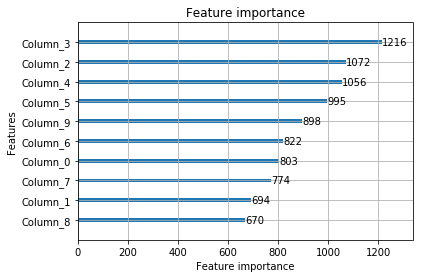

In [190]:
lgb.plot_importance(pca_cl)

In [197]:
np.argmax(pca.components_[3])

67